In [ ]:
#!pip install quantstats

In [301]:
import pandas as pd, numpy as np
import requests, json
import quantstats as qs

In [302]:
res = requests.get("https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=1095")


In [303]:
js = json.loads(res.content)
data = js['Data']['Data']
sdf = pd.DataFrame(data)
sdf['time'] = pd.to_datetime(sdf['time'], unit='s')
df = sdf.copy()
df.head(5)

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,2018-08-01,7760.74,7449.31,7736.25,78466.58,5.954048e+08,7610.90,direct,
1,2018-08-02,7713.32,7470.86,7610.90,55711.79,4.240936e+08,7542.34,direct,
2,2018-08-03,7542.49,7296.76,7542.34,79126.57,5.869825e+08,7417.60,direct,
3,2018-08-04,7490.89,6940.15,7417.60,74300.44,5.340029e+08,7017.89,direct,
4,2018-08-05,7092.53,6898.31,7017.89,52556.01,3.689140e+08,7042.39,direct,


Signal Generation: This is a TrendFollowing Strategy

Also, the signal are generated on close, positions are taken on next open, that is why pos is created by shifting the signal colum by 2 places down.

An important part of Trend Following Strategy is transaction cost, to have a fair comparison with Buy-and-Hold

In [304]:
df.set_index('time',inplace=True)
df['ma10']  = df['close'].rolling(10).mean()
df['ma50']  = df['close'].rolling(50).mean()
df['r'] = df['open'].pct_change()
df['vol'] = df['r'].rolling(60).std(ddof=1)*np.sqrt(365)
df['signal'] = np.where(df.ma10>df.ma50,1,-1)
df['pos'] = df['signal'].shift(2) # Shifted 2 because you have to multiply it by realised gains
df['strategy'] = df['r'].shift(0)*df['pos'] 
df.dropna(inplace=True)

Transaction Costs are set as .75 % * turnover

<AxesSubplot:xlabel='time'>

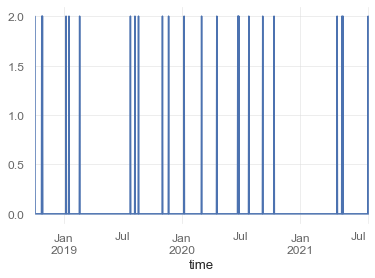

In [305]:
tc_cost = .0075
df['turnover'] = df['signal'].shift(1).diff().abs() #because actual turover happenig a day before that is on next open from Signal day
df['turnover'] = df['turnover'].fillna(df.pos.values[0])
df['turnover'].plot()

In [306]:
df['strategy_with_txn'] = df['strategy'] - df['turnover']*tc_cost

The Strategy hardly beats Buy and Hold if we take txn costs into account, without txn cost the strategy returns are a lot better.

Whta is worrying here is Max Drawdon, Trend following generally exposes us to massive drawdown, more so for an asset like BTC, what we would like to improve in the strategy:

Rather than doing optimizations around MA parameters we will try to control the exposure, position sizing Via Tgt Volatility.

We will tgt the volatility of the underlying asset, another way to tgt volatility is to do it on any strategy equity curve which infact is very similar to Kelly Criterion Bets 

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2018-09-30  2018-09-30
End Period                 2021-07-31  2021-07-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          350.16%     536.46%
CAGR%                      69.99%      92.07%

Sharpe                     0.89        1.03
Sortino                    1.36        1.52
Sortino/√2                 0.96        1.08

Max Drawdown               -57.94%     -61.92%
Longest DD Days            550         483
Volatility (ann.)          64.11%      63.81%
R^2                        0.0         0.0
Calmar                     1.21        1.49
Skew                       0.82        -0.51
Kurtosis                   9.63        10.11

Expected Daily %           0.15%       0.18%
Expected Monthly %         4.39%       5.43%
Expected Yearly %          45.66%      58.83%
Kelly Criterion            9.28%

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-06-28,2020-04-21,2020-12-29,550,-57.936416,-57.072109
2,2021-04-15,2021-05-15,2021-07-31,107,-47.193728,-46.782647
3,2018-12-17,2019-03-05,2019-05-12,146,-43.145002,-41.910316
4,2021-01-10,2021-01-28,2021-02-09,30,-25.133206,-24.106413
5,2021-02-23,2021-03-01,2021-03-12,17,-21.244007,-19.625143


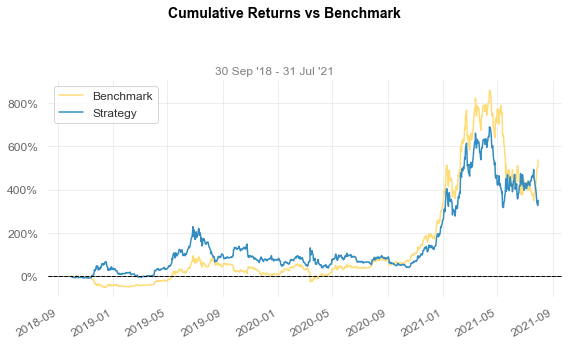

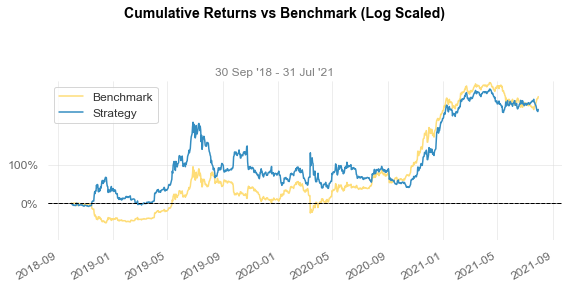

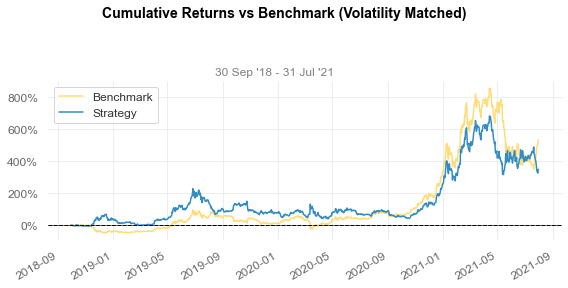

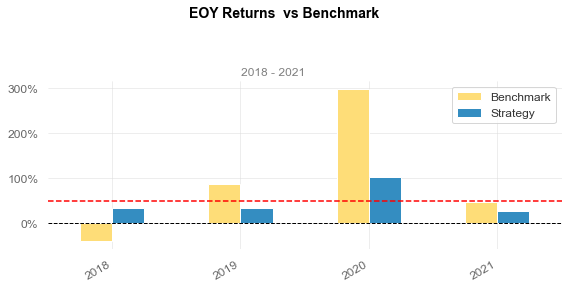

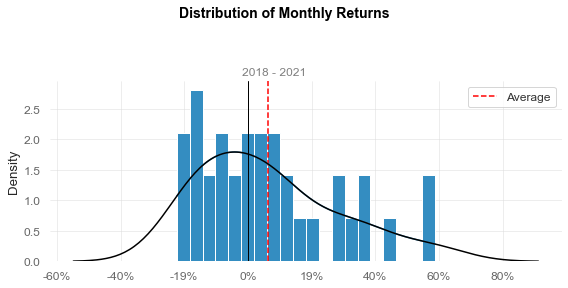

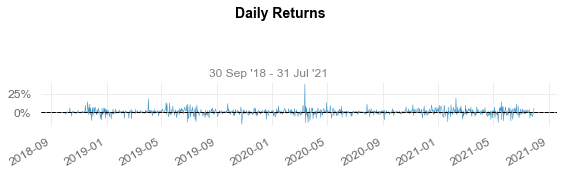

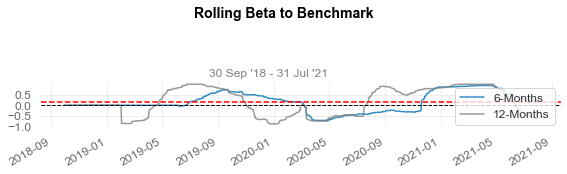

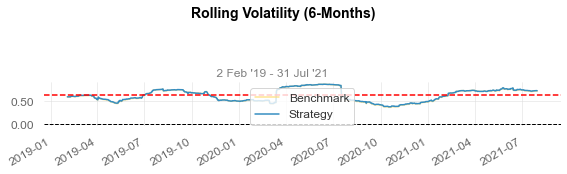

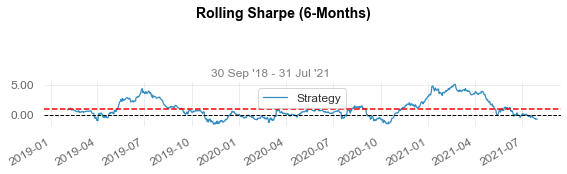

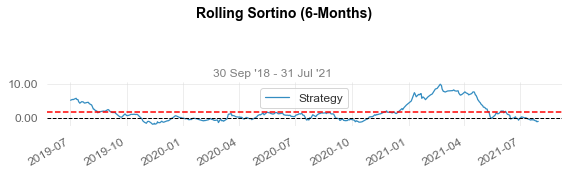

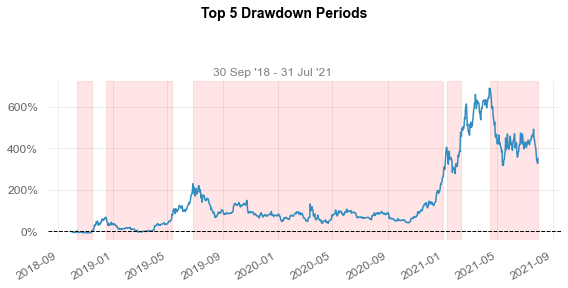

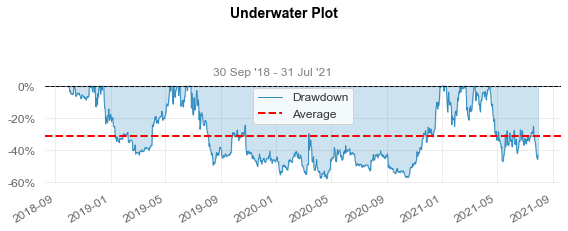

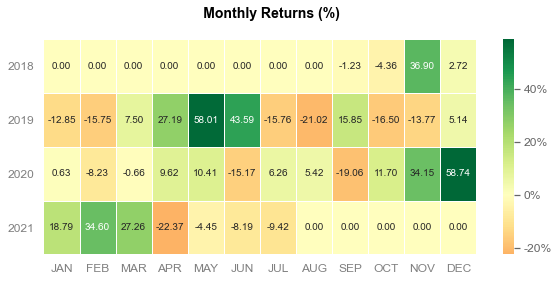

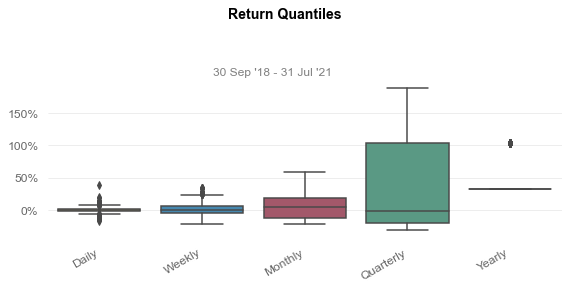

In [307]:
qs.reports.full(df['strategy_with_txn'],df['r'])

<AxesSubplot:xlabel='time'>

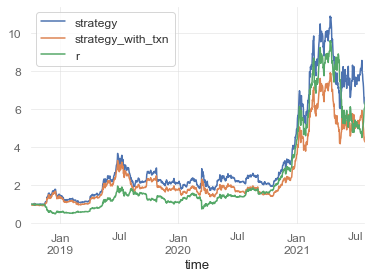

In [308]:
(1.+df[['strategy','strategy_with_txn','r']]).cumprod().plot()

Strat without TXN Costs

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2018-09-30  2018-09-30
End Period          2021-07-31  2021-07-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   560.0%      536.46%
CAGR%               94.54%      92.07%

Sharpe              1.03        1.03
Sortino             1.6         1.52
Sortino/√2          1.13        1.08

Max Drawdown        -52.89%     -61.92%
Longest DD Days     539         483

Gain/Pain Ratio     0.22        0.22
Gain/Pain (1M)      1.8         1.44

Payoff Ratio        1.09        1.09
Profit Factor       1.22        1.22
Common Sense Ratio  1.35        1.45
CPC Index           0.71        0.72
Tail Ratio          1.11        1.19
Outlier Win Ratio   4.19        4.24
Outlier Loss Ratio  4.24        4.18

MTD                 -8.05%      17.63%
3M                  -14.72%     -23.04%
6M                  26.9%       38.82%
YTD                 33.63%   

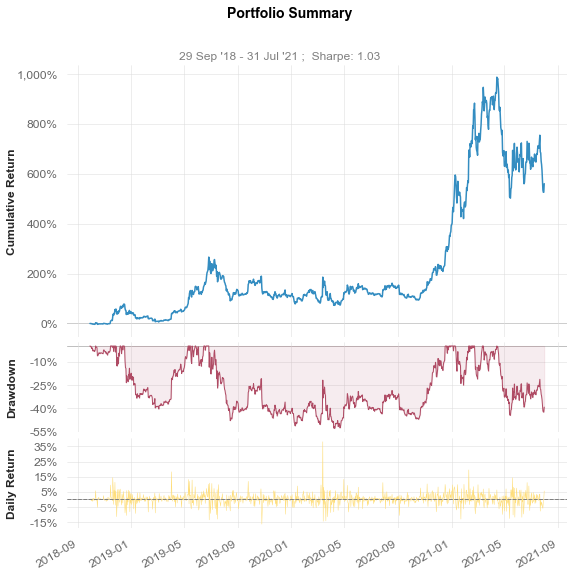

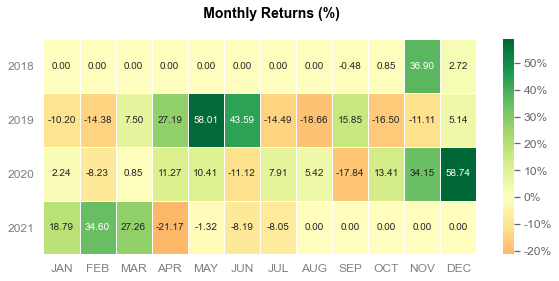

In [309]:
qs.reports.basic(df['strategy'],df.r)

As we can see without txn costs the strategy performs a lot better than Buy and Hold, but a more realistic scenario is with txn cost

In [310]:
df['drawdown'] = (1+df.strategy).cumprod()/(1+df.strategy).cumprod().cummax()-1

In [311]:
tgt_vol = .30
df['tgt_multiplier'] = .3/df['vol']
df['tgt_multiplier'] = df['tgt_multiplier'].apply(lambda x: min(x,1.)).shift(1)
df['tgt_multiplier'] = np.where(df.pos!=df.pos.shift(1),df['tgt_multiplier'],np.nan)
df['tgt_multiplier'] = df['tgt_multiplier'].fillna(method='ffill')

<AxesSubplot:xlabel='time'>

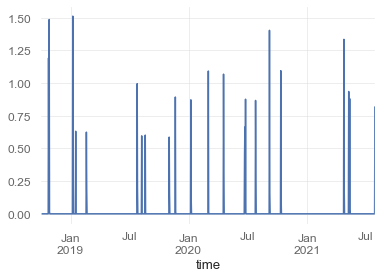

In [313]:
df['turnover'] = (df['tgt_multiplier']*df['signal'].shift(1)).diff().abs() #Turnover happening the prior day
df['turnover'] = df['turnover'].fillna((df['pos']*df['tgt_multiplier']).values[0])#First val
df['turnover'].plot()

In [315]:
df['overlayed_pos'] = df['tgt_multiplier']*df['pos']*df['r']
df['overlayed_pos_txn'] = df['overlayed_pos']-df['turnover']*tc_cost

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2018-09-30  2018-09-30
End Period                 2021-07-31  2021-07-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          272.66%     536.46%
CAGR%                      59.03%      92.07%

Sharpe                     1.09        1.03
Sortino                    1.75        1.52
Sortino/√2                 1.24        1.08

Max Drawdown               -29.09%     -61.92%
Longest DD Days            516         483
Volatility (ann.)          34.77%      63.81%
R^2                        0.0         0.0
Calmar                     2.03        1.49
Skew                       1.04        -0.51
Kurtosis                   10.46       10.11

Expected Daily %           0.13%       0.18%
Expected Monthly %         3.83%       5.43%
Expected Yearly %          38.94%      58.83%
Kelly Criterion            10.71

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-06-28,2020-10-17,2020-11-25,516,-29.094618,-28.313730
2,2021-04-15,2021-05-15,2021-07-31,107,-28.628742,-28.385399
3,2018-12-17,2019-03-05,2019-05-12,146,-26.632749,-25.848281
4,2021-01-10,2021-01-28,2021-02-09,30,-17.052528,-16.386876
5,2021-02-23,2021-03-01,2021-03-12,17,-14.562070,-13.397954


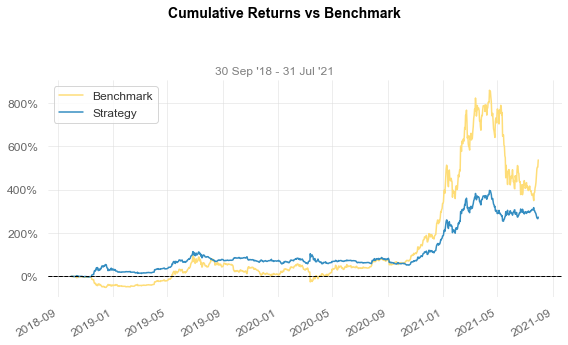

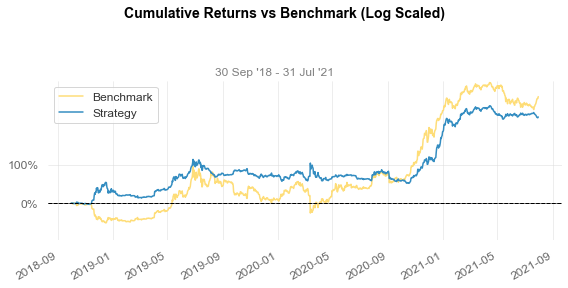

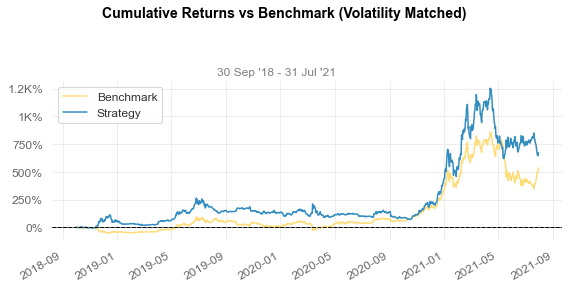

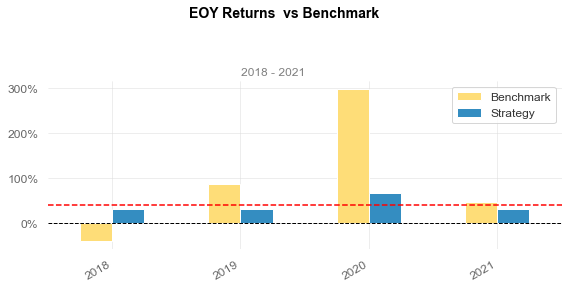

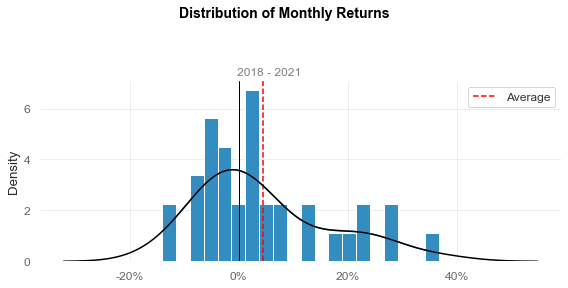

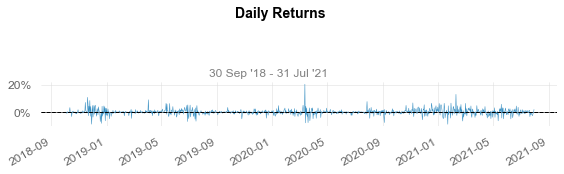

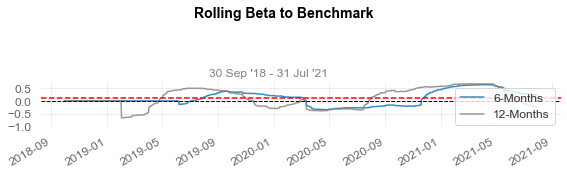

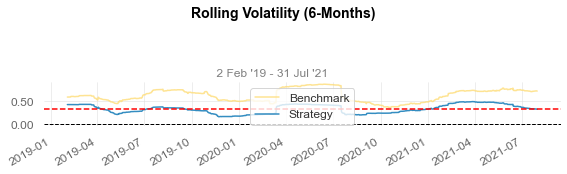

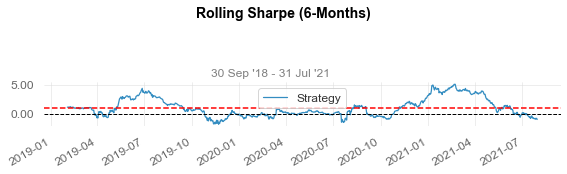

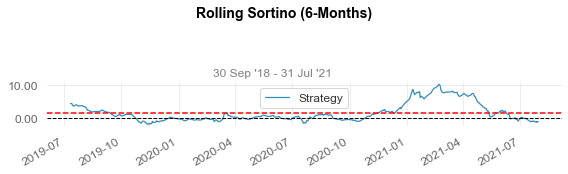

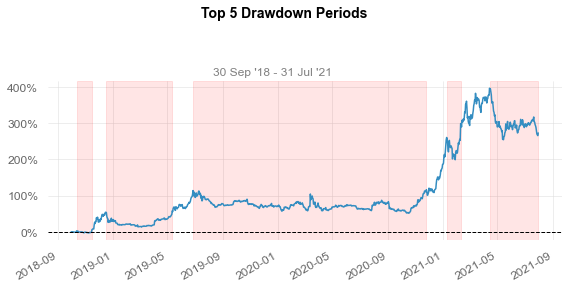

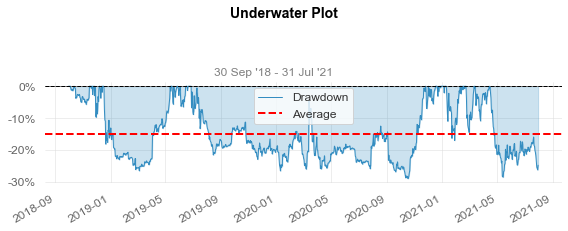

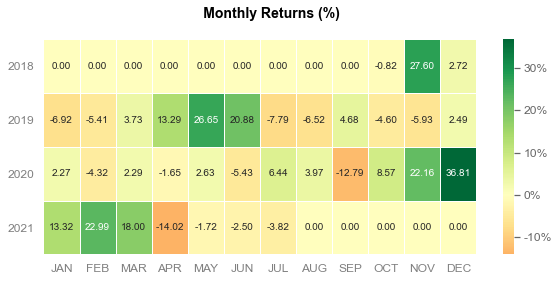

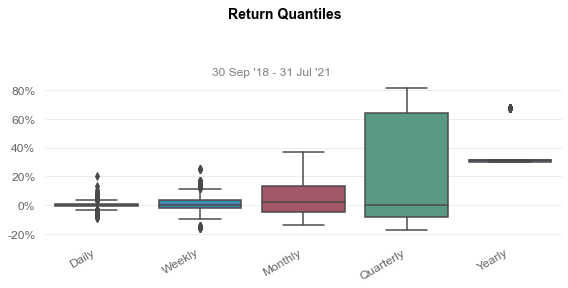

In [316]:
qs.reports.full(df['overlayed_pos_txn'],df['r'])

<AxesSubplot:xlabel='time'>

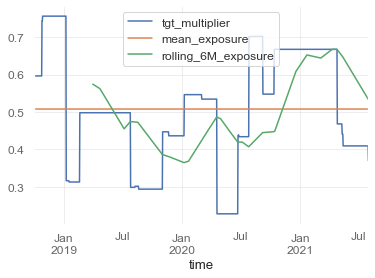

In [317]:
df['rolling_6M_exposure'] = df['tgt_multiplier'].rolling(180).mean()
df['mean_exposure'] = df['tgt_multiplier'].mean()
df[['tgt_multiplier','mean_exposure','rolling_6M_exposure']].plot()

The tgt vol strategy though having a low absolute return (which was expected as the tgt vol exposure will be lower than 1, and we do not allow any leverage), has generated a better sharpe than both buy and hold and basic strategy

What is more pleasant is that it does so at less than half the drawdown


The avergae exposure also hover around 50-65% range, so keeping the cash free to be deployed tosome other strategies


Remember we have tested a very naive strategy of tgt vol, we can certianly do better if we take lower and upper deviations separately, using ewma for vol calcs, and other stuff

Tgt Vol overlayed w/o Txn Costs

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2018-09-30  2018-09-30
End Period          2021-07-31  2021-07-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   347.82%     536.46%
CAGR%               69.67%      92.07%

Sharpe              1.22        1.03
Sortino             1.97        1.52
Sortino/√2          1.39        1.08

Max Drawdown        -26.74%     -61.92%
Longest DD Days     259         483

Gain/Pain Ratio     0.28        0.22
Gain/Pain (1M)      2.52        1.44

Payoff Ratio        1.13        1.09
Profit Factor       1.28        1.22
Common Sense Ratio  1.62        1.45
CPC Index           0.77        0.71
Tail Ratio          1.27        1.19
Outlier Win Ratio   6.34        3.38
Outlier Loss Ratio  6.45        3.22

MTD                 -3.2%       17.63%
3M                  -4.85%      -23.04%
6M                  28.89%      38.82%
YTD                 34.63%   

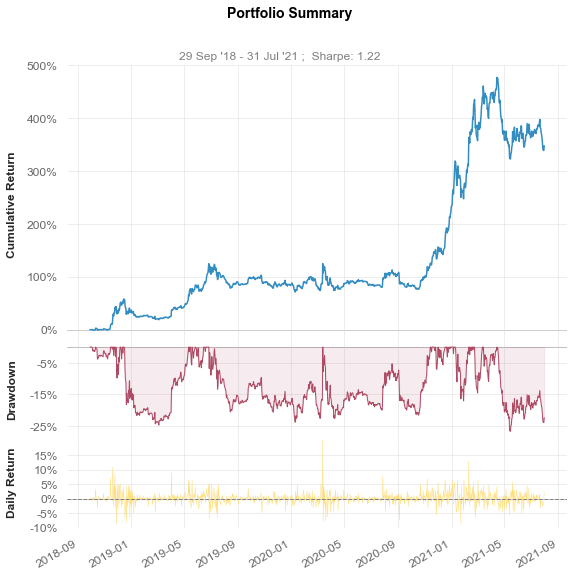

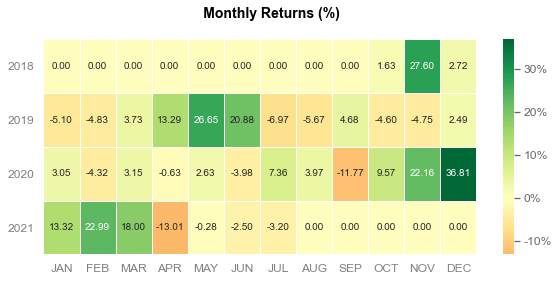

In [318]:
qs.reports.basic(df['overlayed_pos'],df['r'])

Some imp issues is days under drawdown and there is lot of scope for improvement in this naive approach

Comarison of two approaches 1st is Tgt Vol Overlayed 2nd is Original Strat both with Txn Cost

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2018-09-30  2018-09-30
End Period                 2021-07-31  2021-07-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          278.17%     355.97%
CAGR%                      59.85%      70.76%

Sharpe                     1.1         0.89
Sortino                    1.77        1.37
Sortino/√2                 1.25        0.97

Max Drawdown               -28.56%     -57.92%
Longest DD Days            512         548
Volatility (ann.)          34.72%      63.92%
R^2                        0.93        0.93
Calmar                     2.1         1.22
Skew                       1.05        0.84
Kurtosis                   10.51       9.71

Expected Daily %           0.13%       0.15%
Expected Monthly %         3.87%       4.43%
Expected Yearly %          39.45%      46.13%
Kelly Criterion            10.54%

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-06-28,2020-10-17,2020-11-21,512,-28.559608,-27.704728
2,2021-04-15,2021-05-15,2021-07-31,107,-28.319276,-27.630037
3,2018-12-17,2019-03-05,2019-05-12,146,-26.142943,-25.353238
4,2021-01-10,2021-01-28,2021-02-09,30,-17.052528,-16.386876
5,2021-02-23,2021-03-01,2021-03-12,17,-14.562070,-13.397954


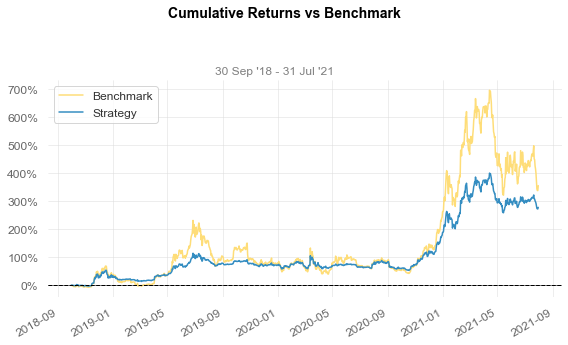

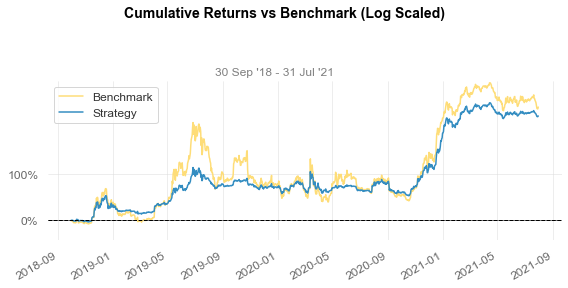

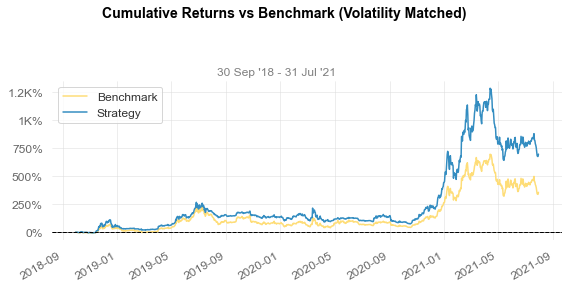

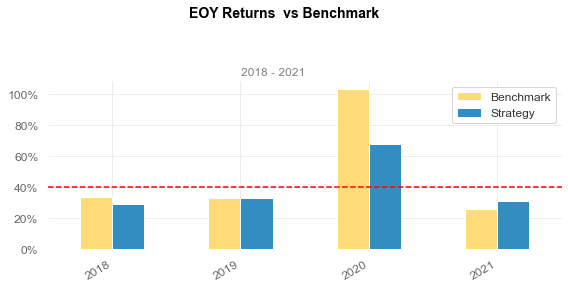

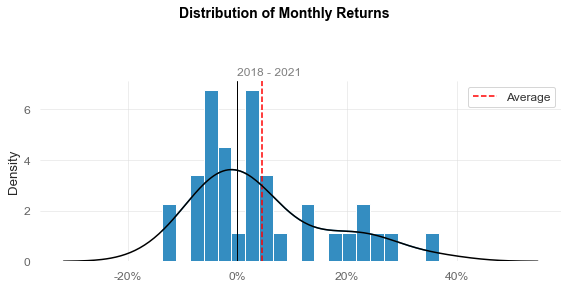

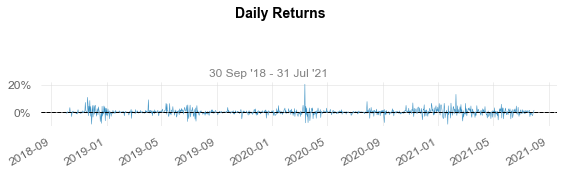

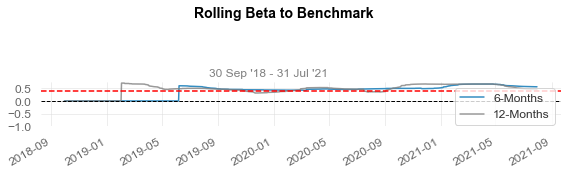

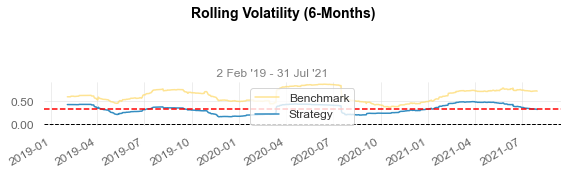

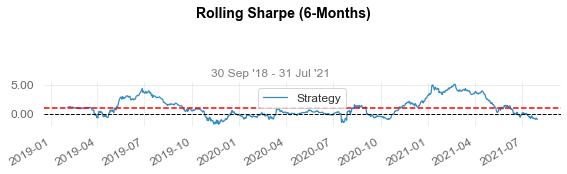

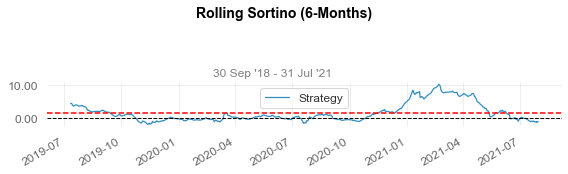

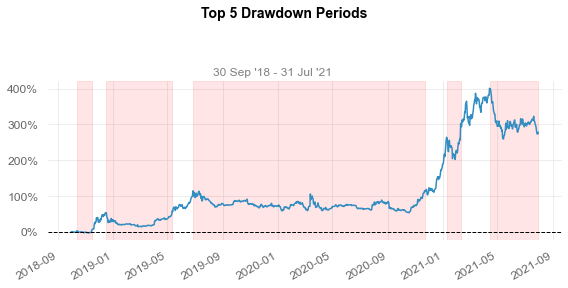

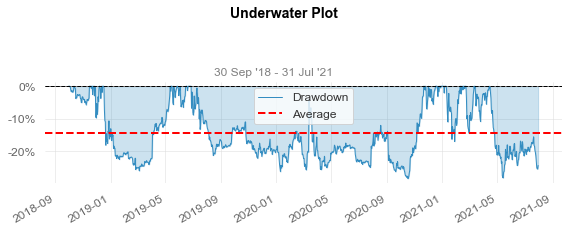

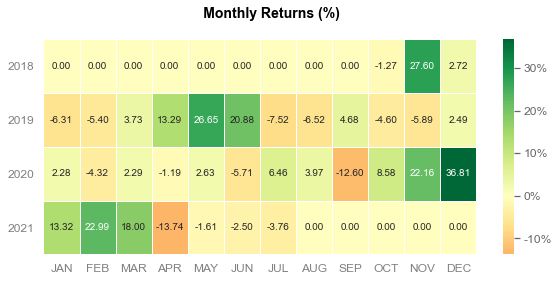

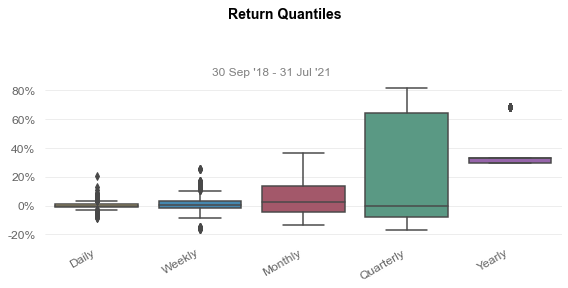

In [300]:
qs.reports.full(df['overlayed_pos_txn'],df['strategy_with_txn'])